# Импорты библиотек

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as st
from datetime import datetime

# Чтение данных

In [2]:
df_path = "marketplace.csv"

df = pd.read_csv(df_path)
display(df.head())
df.info()

,user_id,platform_num,first_login,reg_dt,browser,first_buy,target,total_buy,total_return
0,user_000000,12,2025-03-22,2024-08-17,browser_00,2025-03-22,0.0,85.329559,0.0
1,user_000001,1,2025-05-05,2025-05-15,browser_01,2025-05-20,0.0,21.819124,0.0
2,user_000002,5,2025-01-19,2025-01-23,browser_02,2025-02-20,0.3,194.612980,485.0
3,user_000003,3,2025-03-15,2023-09-05,browser_02,NaN,0.0,138.780814,0.0
4,user_000004,1,2025-05-05,2025-05-14,browser_00,2025-05-11,0.0,16.334507,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25335 entries, 0 to 25334
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   user_id       25335 non-null  object 
 1   platform_num  25335 non-null  int64  
 2   first_login   25335 non-null  object 
 3   reg_dt        25331 non-null  object 
 4   browser       25335 non-null  object 
 5   first_buy     24361 non-null  object 
 6   target        25335 non-null  float64
 7   total_buy     25335 non-null  float64
 8   total_return  25335 non-null  float64
dtypes: float64(3), int64(1), object(5)
memory usage: 1.7+ MB


# Чистка данных

Очищенные данные кладем в переменную df_cleaned. 

После очистки запишем данные в новый файл marketplace_cleaned.csv для быстрого доступа к ним.
1. Преобразовать типов
1. Дубли юзеров сливаем в одну запись суммируя покупки и возвраты, таргет - среднее
1. Формат данных - юзеров делаем индексами
1. Заполнить пустые даты. Отбросить выбросы. Взять среднее кол-во дней между датой регистрации и датой покупки. Заполнить пустые даты регистрации вычитая среднее кол-во дней между покупкой и регистрацией.


## Преобразование типов

In [3]:
df_cleaned = pd.DataFrame(data=df)

df_cleaned["reg_dt"] = pd.to_datetime(df_cleaned["reg_dt"], errors="coerce")
df_cleaned["first_buy"] = pd.to_datetime(df_cleaned["first_buy"], errors="coerce")
df_cleaned["first_login"] = pd.to_datetime(df_cleaned["first_login"], errors="coerce")

df_cleaned["user_id"] = df_cleaned["user_id"].apply(lambda x: int(x.strip("user_")))
df_cleaned["browser"] = df_cleaned["browser"].apply(lambda x: int(x.strip("browser_")))

## Заполнение нулей

In [4]:
df_cleaned["first_buy"].fillna(df_cleaned[['first_login', 'reg_dt']].max(axis=1), inplace=True)

## Склеивание дублей и индексация по user_id

In [5]:
df_cleaned = df_cleaned.groupby(by="user_id").agg(
    {
        "platform_num": "min",
        "first_login": "min",
        "reg_dt": "min",
        "browser": "min",
        "first_buy": "min",
        "target": "mean",
        "total_buy": "sum",
        "total_return": "sum",
    }
)
print(len(df_cleaned))
df_cleaned.head()

25331


,platform_num,first_login,reg_dt,browser,first_buy,target,total_buy,total_return
user_id,,,,,,,,
0,12,2025-03-22,2024-08-17,0,2025-03-22,0.0,85.329559,0.0
1,1,2025-05-05,2025-05-15,1,2025-05-20,0.0,21.819124,0.0
2,5,2025-01-19,2025-01-23,2,2025-02-20,0.3,194.612980,485.0
3,3,2025-03-15,2023-09-05,2,2025-03-15,0.0,138.780814,0.0
4,1,2025-05-05,2025-05-14,0,2025-05-11,0.0,16.334507,0.0


In [6]:
df_cleaned.loc[(df_cleaned['reg_dt'] > df_cleaned['first_buy']), ['reg_dt']] = df_cleaned['first_buy']
df_cleaned.loc[(df_cleaned['first_login'] > df_cleaned['first_buy']), ['first_login']] = df_cleaned['first_buy']

## Проверить на нормальность распределения

## Проверить равенство дисперсий

## Посчитать межквартильный размах

## Посчитать zscore

## Убрать выбросы по межквартильному размаху

## Убрать выбросы по zscore

In [7]:
df_zcore_filtered = pd.DataFrame(data=df_cleaned)

df_zcore_filtered = df_zcore_filtered[
    (abs(st.zscore(df_cleaned["total_buy"])) < 3)
    & (abs(st.zscore(df_cleaned["total_return"])) < 3)
]
print(len(df_zcore_filtered))
df_zcore_filtered.head()

25094


,platform_num,first_login,reg_dt,browser,first_buy,target,total_buy,total_return
user_id,,,,,,,,
0,12,2025-03-22,2024-08-17,0,2025-03-22,0.0,85.329559,0.0
1,1,2025-05-05,2025-05-15,1,2025-05-20,0.0,21.819124,0.0
2,5,2025-01-19,2025-01-23,2,2025-02-20,0.3,194.612980,485.0
3,3,2025-03-15,2023-09-05,2,2025-03-15,0.0,138.780814,0.0
4,1,2025-05-05,2025-05-11,0,2025-05-11,0.0,16.334507,0.0


## Наблюдаемые ошибки в датах. Даты не соответствуют порядку: дата первого логина -> дата первой покупки

In [8]:
def difference(dataset, first_dt, second_dt):
    return dataset[first_dt] - dataset[second_dt]

print('\nBefore cleaning:')
print(f'Первая покупка раньше регистрации у {len(df.loc[(df['reg_dt'] > df['first_buy'])])} из {len(df)}')
print(f'Первая покупка раньше первого логина у {len(df.loc[(df['first_login'] > df['first_buy'])])} из {len(df)}')
print(f'Оба условия (или) у {len(df.loc[(df['first_login'] > df['first_buy']) | (df['reg_dt'] > df['first_buy'])])} из {len(df)}')

print('\nAfter cleaning:')
print(f'Первая покупка раньше регистрации у {len(df_cleaned.loc[(df_cleaned['reg_dt'] > df_cleaned['first_buy'])])} из {len(df_cleaned)}')
print(f'Первая покупка раньше первого логина у {len(df_cleaned.loc[(df_cleaned['first_login'] > df_cleaned['first_buy'])])} из {len(df_cleaned)}')
print(f'Средняя разница дат - {difference(df_cleaned.loc[(df_cleaned['first_login'] > df_cleaned['first_buy'])], 'first_login', 'first_buy').mean()}')
print(f'Оба условия (или) у {len(df_cleaned.loc[(df_cleaned['first_login'] > df_cleaned['first_buy']) | (df_cleaned['reg_dt'] > df_cleaned['first_buy'])])} из {len(df_cleaned)}')

print('\nAfter cleaning without outlines:')
print(f'Первая покупка раньше регистрации у {len(df_zcore_filtered.loc[(df_zcore_filtered['reg_dt'] > df_zcore_filtered['first_buy'])])} из {len(df_zcore_filtered)}')
print(f'Первая покупка раньше первого логина у {len(df_zcore_filtered.loc[(df_zcore_filtered['first_login'] > df_zcore_filtered['first_buy'])])} из {len(df_zcore_filtered)}')
print(f'Оба условия (или) у {len(df_zcore_filtered.loc[(df_zcore_filtered['first_login'] > df_zcore_filtered['first_buy']) | (df_zcore_filtered['reg_dt'] > df_zcore_filtered['first_buy'])])} из {len(df_zcore_filtered)}')


Before cleaning:
Первая покупка раньше регистрации у 7543 из 25335
Первая покупка раньше первого логина у 10218 из 25335
Оба условия (или) у 12875 из 25335

After cleaning:
Первая покупка раньше регистрации у 0 из 25331
Первая покупка раньше первого логина у 0 из 25331
Средняя разница дат - NaT
Оба условия (или) у 0 из 25331

After cleaning without outlines:
Первая покупка раньше регистрации у 0 из 25094
Первая покупка раньше первого логина у 0 из 25094
Оба условия (или) у 0 из 25094


## Повторить проверки на нормальность и равество дисперсий после исключения выбросов по межквартильному размаху

## Повторить проверки на нормальность и равество дисперсий после исключения выбросов по zscore

In [9]:
# fig, ax = plt.subplots(figsize=(16, 6))

# sns.scatterplot(data=df_zcore_filtered, x="browser", y="target", hue="total_buy")

# plt.show()

In [10]:
# Импульсивные покупки
# sns.scatterplot(data=df_zcore_filtered, x="first_login", y="first_buy", hue="total_buy")


Добавим в датафрейм день недели и день месяца

In [11]:
# fig, ax = plt.subplots(figsize=(16, 6))
# df_zcore_filtered["reg_wday"] = df_zcore_filtered["reg_dt"].apply(lambda x: x.weekday())
# df_zcore_filtered["login_wday"] = df_zcore_filtered["first_login"].apply(lambda x: x.weekday())
# df_zcore_filtered["buy_wday"] = df_zcore_filtered["first_buy"].apply(
#     lambda x: x.weekday()
# )
# df_zcore_filtered["reg_mday"] = df_zcore_filtered["reg_dt"].apply(lambda x: x.day)
# df_zcore_filtered["login_mday"] = df_zcore_filtered["first_login"].apply(lambda x: x.day)
# df_zcore_filtered["buy_mday"] = df_zcore_filtered["first_buy"].apply(
#     lambda x: x.day
# )

# sns.scatterplot(
#     data=df_zcore_filtered,
#     x="login_mday",
#     y="total_buy",
#     hue="buy_wday",
# )

# plt.show()

# Гипотезы

### Рассмотрим следующие гипотезы:
 1. Влияние заранее зарегистрировавшихся пользователей (задолго до первого логина/покупки) и пользователей, которые произвели покупку до регистрации
 2. Таргет может влиять на покупки или наоборот
 3. Влияние браузера на прибыльность или на скорость покупки.
 4. Рассмотреть превалирирование определённого браузера/браузеров у юзеров, совершивших больше всего возвратов.
 5. Аномальные всплески покупок/возвратов за весь период анализа. Привязка к другим данным? Праздникам?

# Стратегия проверки: Строим графики, смотрим результаты, считаем. Думаем. Повторяем. (кто-нибудь помогите с формулировкой, пожалуйста)


### Гипотеза №1 "Консервы"
_Влияние заранее зарегистрировавшихся пользователей и пользователей, которые произвели покупку до регистрации_

На выдвижение данной гипотезы меня натолкнула идея построения графиков зависимостей всех трёх дат (регистрация, первый логин, первая покупка) попарно, в поисках аномалий.

In [12]:
# обогащу таблицу разницей времени между тремя событиями
df_enriched = df_zcore_filtered.copy()

df_enriched["first_buy_reg_diff"] = (
    df_zcore_filtered["first_buy"] - df_zcore_filtered["reg_dt"]
).dt.days
df_enriched["first_login_buy_diff"] = (
    df_zcore_filtered["first_login"] - df_zcore_filtered["first_buy"]
).dt.days
df_enriched["first_login_reg_diff"] = (
    df_zcore_filtered["first_login"] - df_zcore_filtered["reg_dt"]
).dt.days
display(df_enriched.head(2))


,platform_num,first_login,reg_dt,browser,first_buy,target,total_buy,total_return,first_buy_reg_diff,first_login_buy_diff,first_login_reg_diff
user_id,,,,,,,,,,,
0,12,2025-03-22,2024-08-17,0,2025-03-22,0.0,85.329559,0.0,217,0,217
1,1,2025-05-05,2025-05-15,1,2025-05-20,0.0,21.819124,0.0,5,-15,-10


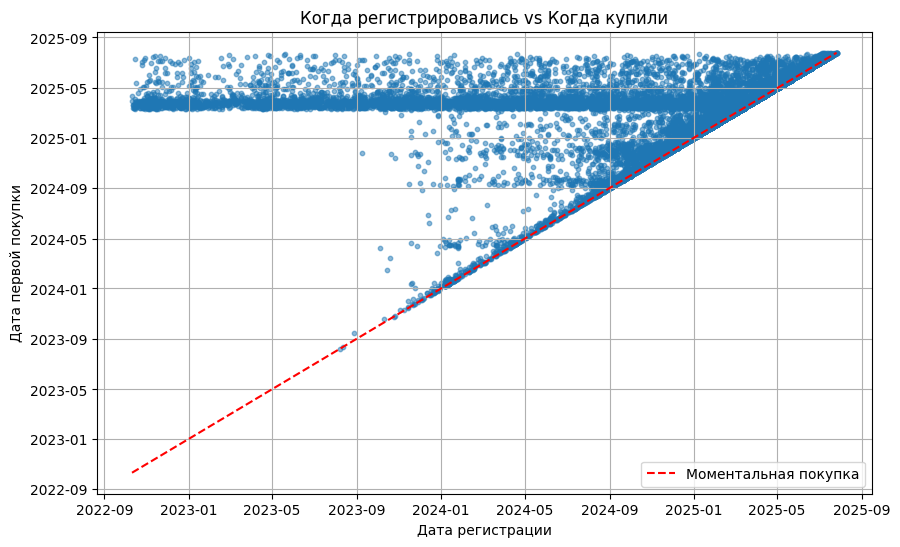

In [13]:
# Строим график зависимости дат регистрации и дат первой покупки
plt.figure(figsize=(10, 6))

# Рисуем точки
plt.scatter(df_enriched["reg_dt"], df_enriched["first_buy"], alpha=0.5, s=10)

# Добавляем линию "мгновенной покупки" (где X=Y), чтобы видеть задержку
# (для наглядности просто проведем диагональ)
min_date = df_enriched["reg_dt"].min()
max_date = df_enriched["first_buy"].max()
plt.plot(
    [min_date, max_date],
    [min_date, max_date],
    color="red",
    linestyle="--",
    label="Моментальная покупка",
)

plt.title("Когда регистрировались vs Когда купили")
plt.xlabel("Дата регистрации")
plt.ylabel("Дата первой покупки")
plt.legend()
plt.grid(True)
plt.show()


Видим аномальные отклонения от предсказуемой красной линии, есть объёмная группа юзеров, что регестрировались на протяжении всего периода, но покупки совершали в марте-апреле 2025. Это требует дополнительных исследований.

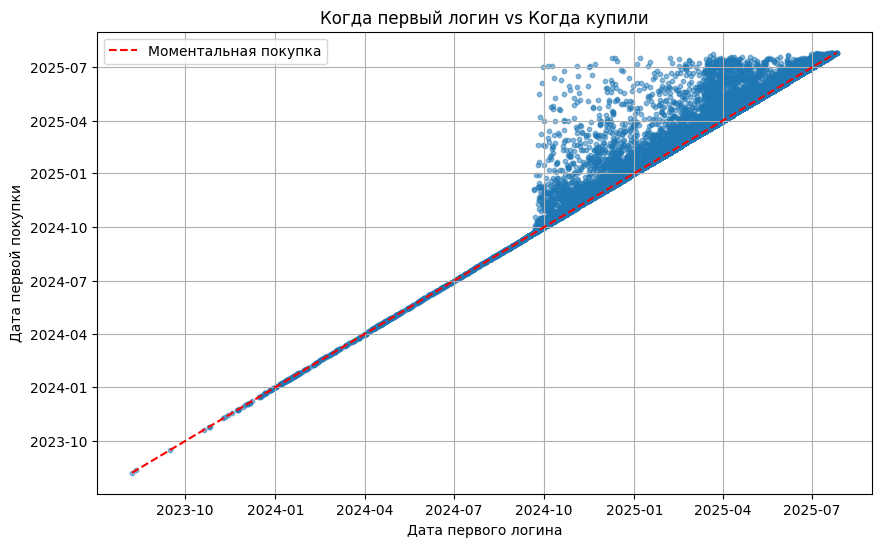

In [14]:
# Строим график зависимости дат первого логина и дат первой покупки
plt.figure(figsize=(10, 6))

# Рисуем точки
plt.scatter(df_enriched["first_login"], df_enriched["first_buy"], alpha=0.5, s=10)

# Добавляем линию "мгновенной покупки" (где X=Y), чтобы видеть задержку
# (для наглядности просто проведем диагональ)
min_date = df_enriched["first_login"].min()
max_date = df_enriched["first_buy"].max()
plt.plot(
    [min_date, max_date],
    [min_date, max_date],
    color="red",
    linestyle="--",
    label="Моментальная покупка",
)

plt.title("Когда первый логин vs Когда купили")
plt.xlabel("Дата первого логина")
plt.ylabel("Дата первой покупки")
plt.legend()
plt.grid(True)
plt.show()


Тут, предварительно, не выводится надёжной визуальной зависимости. Вертикальная разряженная линия появилась из-за заполнения значений first_buy от reg_dt, который не учавствует в данном графике.
Это, дополнительно, проверяется отстройкой подобного графика на неочищенных данных:
# Возможно лишний график стоит убрать, он вызовет вопросы, а я отвечаю на то, о чём нас и не спрашивали.
<!-- ![image.png](attachment:image.png) -->

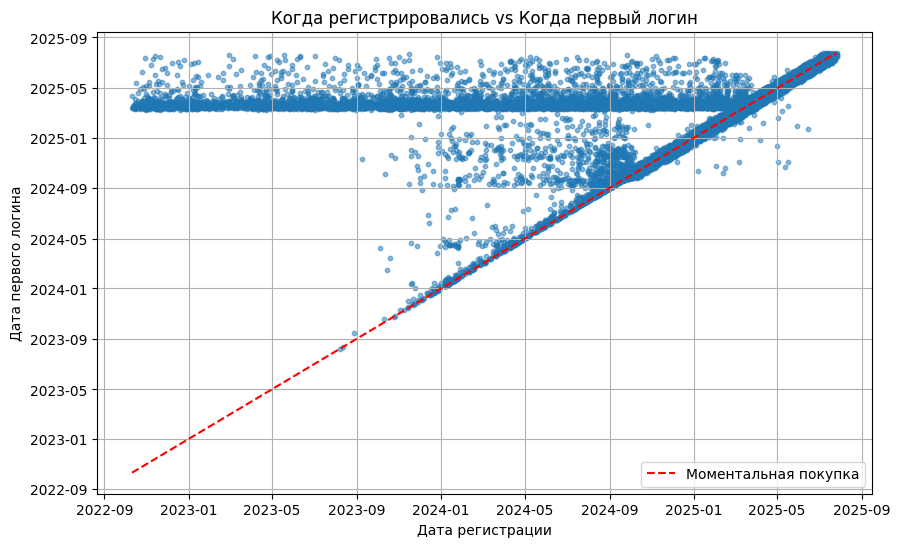

In [15]:
# Строим график зависимости дат регистрации и дат первого логина
plt.figure(figsize=(10, 6))

# Рисуем точки
plt.scatter(df_enriched["reg_dt"], df_enriched["first_login"], alpha=0.5, s=10)

# Добавляем линию "мгновенной покупки" (где X=Y), чтобы видеть задержку
# (для наглядности просто проведем диагональ)
min_date = df_enriched["reg_dt"].min()
max_date = df_enriched["first_login"].max()
plt.plot(
    [min_date, max_date],
    [min_date, max_date],
    color="red",
    linestyle="--",
    label="Моментальная покупка",
)

plt.title("Когда регистрировались vs Когда первый логин")
plt.xlabel("Дата регистрации")
plt.ylabel("Дата первого логина")
plt.legend()
plt.grid(True)
plt.show()


Видим аномалию, аналогичную первому графику, соответственно регистрация была давно, а первая покупка и логин (если это одни и те же пользователи) произведены в марте-апреле 2025.
Также заметен дополнительный аномальный интервал к концу 2024 года, также требующий анализа.

Для проведения анализа планируется выборка клиентов с "лагом" в датах более ~30-50 дней и сравнение их финансового вклада по сравнению с остальными пользователями.

### Гипотеза №4 "Браузерные войны!"
_Предпочтения браузера у юзеров, совершивших больше всего покупок/возвратов._

Рассмотрим корреляцию используемых браузеров юзерами.

In [16]:
# Укажите список + стратегию проверки